In [1]:
import pandas as pd
from matplotlib import cm
import matplotlib.pyplot as plt
import numpy as np
import glob
import scipy.stats as sts
import ast
from scipy.interpolate import interp1d
from collections import OrderedDict
from matplotlib.transforms import blended_transform_factory
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
plt.close('all')
plt.style.use('default')
plt.rc('font', family='serif')
plt.rc('text', usetex=True)

LEGEND_FONT_SIZE = 12
AXIS_FONT_SIZE = 16
TICKS_FONT_SIZE = 12

figs = []
%matplotlib inline
def running_mean(x, N):
    divider = np.convolve(np.ones_like(x), np.ones((N,)), mode='same')
    return np.convolve(x, np.ones((N,)), mode='same') / divider

In [2]:
linestyles = OrderedDict(
    [('solid',               (0, ())),
     ('loosely dotted',      (0, (1, 10))),
     ('dotted',              (0, (1, 5))),
     ('densely dotted',      (0, (1, 1))),

     ('loosely dashed',      (0, (5, 10))),
     ('dashed',              (0, (5, 5))),
     ('densely dashed',      (0, (5, 1))),

     ('loosely dashdotted',  (0, (3, 10, 1, 10))),
     ('dashdotted',          (0, (3, 5, 1, 5))),
     ('densely dashdotted',  (0, (3, 1, 1, 1))),

     ('loosely dashdotdotted', (0, (3, 10, 1, 10, 1, 10))),
     ('dashdotdotted',         (0, (3, 5, 1, 5, 1, 5))),
     ('densely dashdotdotted', (0, (3, 1, 1, 1, 1, 1))),

     ('loosely dashdashdotted', (0, (3, 10, 3, 10, 1, 10))),
     ('dashdashdotted',         (0, (3, 5, 3, 5, 1, 5))),
     ('densely dashdashdotted', (0, (3, 1, 3, 1, 1, 1)))])

ls = [linestyles['solid'], linestyles['dashed'], linestyles['dotted'], 
      linestyles['dashdotted'], linestyles['dashdotdotted'], linestyles['dashdashdotted'],
      linestyles['densely dashed'], linestyles['densely dotted']]

colors = ['r', 'b', 'g','orange','c', 'k','purple', 'y']

In [4]:
def plot_ci(xs, ys, conf, n, xlabel=None, ylabel=None, label=None, ax=None, **kwargs):
    
    if np.array(xs).ndim > 1:
        all_x = np.array(list(set(np.concatenate(xs).ravel().tolist())))
        all_x = np.sort(all_x)
        last_x = min(map(lambda x: max(x), xs))
        first_x = max(map(lambda x: min(x), xs))
        all_ys = []

        pred_x = np.linspace(first_x, last_x, 200)

        for i in range(len(xs)):
            f = interp1d(xs[i], ys[i], "linear")
            all_ys.append(f(pred_x))
        all_ys = np.array(all_ys)
    else:
        all_x = xs
        all_ys = ys
        pred_x = xs
    
    data_mean = np.mean(all_ys, axis=0)
    data_std = np.std(all_ys, axis=0) + 1e-24
    interval = sts.t.interval(conf, n-1,loc=data_mean,scale=data_std/np.sqrt(n))

    col = kwargs.get('color')
    if ax is None:
        fig, ax = plt.subplots(figsize=(4.8, 3.2))
        figs.append(fig)
    if label is None:
        ax.plot(pred_x, data_mean, **kwargs)
    else:
        ax.plot(pred_x, data_mean, label=label, **kwargs)
        
    if col is not None:
        ax.fill_between(pred_x, interval[0], interval[1], alpha=0.2, color=col, linewidth=0.)
    else:
        ax.fill_between(pred_x, interval[0], interval[1], alpha=0.2, linewidth=0.)
        
    if xlabel is not None:
        ax.set_xlabel(xlabel, fontsize=AXIS_FONT_SIZE)
    if ylabel is not None:
        ax.set_ylabel(ylabel, fontsize=AXIS_FONT_SIZE)
    return ax

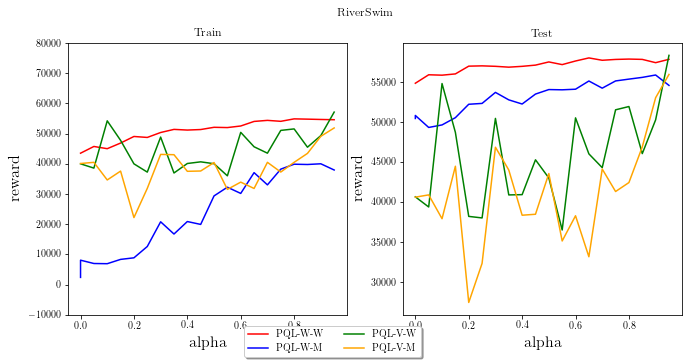

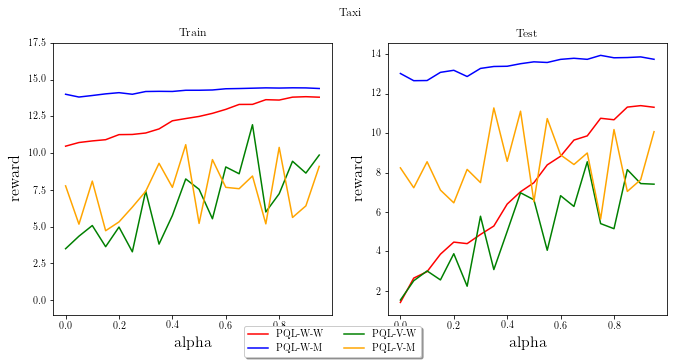

In [12]:
environments = ['RiverSwim','Taxi']
algorithms = ['particle-ql']
policies = [['weighted','vpi'],['boot','weighted'],['eps-greedy', 'boltzmann']]
updates = [['weighted','mean'],[''], ['']]
alg_to_label={
        'particle-ql':'PQL',
        'ql':'QL',
        'boot-ql':'BQL'
}
policy_to_label={
        'weighted':'W',
        'vpi':'V',
        'eps-greedy':'e-Gree',
        'boltzmann':'Boltz',
        'boot':'Boot'
}
update_to_label={
        'weighted':'W',
        'mean':'M',
        '':''
}
conf = 0.95
max_alpha=1
delta_alpha=0.05
limits=[(-10000,80000),(-1,17.5),(0,420),(0,50),(0,110000),(-200,10)]
for e,env in enumerate(environments):
    fig, ax = plt.subplots(1, 2, figsize=(11, 5))
    fig.suptitle(env)
    i = 0    
    for j, alg in enumerate(algorithms):
        for pi in policies[j]:
            for u in updates[j]:
                
                xs=[]
                ys=[]
                zs_train=[]
                zs_test=[]
                data_std_train=[]
                data_std_test=[]
                #print("%s_%s" %(pi,u))
                #results_noise_weighted_20_mean_0.2_1539254826.2738013_coef=0.15000000000000002.npy
                paths = glob.glob("./noise_tests/"+env + "/results_noise_" + pi + "_*_"+ u + "_*_*_coef=*.npy")
                #print(paths)
                for p in paths:
                        alpha=float(str.split(p,'=')[1][:-4])
                        xs.append(alpha)
                        results = np.load(p)
                        #print(results.shape)
                        n_runs = results.shape[0]
                        try:
                            timesteps = np.cumsum(results[:, 0, :, 0][0])
                            cum_reward_train = results[:, 0, :, 3]
                            cum_reward_test = results[:, 1, :, 3]
                        except:
                            b = np.zeros(shape=results.shape+(11,))
                            for  (x,h,k),value in np.ndenumerate(results):
                                for l in range(11):
                                    b[x,h,k,l]=results[x,h,k][l]
                            results=b
                            timesteps = np.cumsum(results[:, 0, :, 0][0])
                            cum_reward_train = results[:, 0, :, 3]
                            cum_reward_test = results[:, 1, :, 3]
                        data_std_train.append(np.std(cum_reward_train, axis=0) + 1e-24)
                        zs_train.append(np.mean(cum_reward_train,axis=0))
                        data_std_test.append(np.std(cum_reward_test, axis=0) + 1e-24)
                        zs_test.append(np.mean(cum_reward_test,axis=0))
                ys=timesteps
                
                zs_train=np.array(zs_train)
                data_std_train=np.array(data_std_train)
                zs_test=np.array(zs_test)
                data_std_test=np.array(data_std_test)
                xs=np.array(xs)
                col = colors[i]
                #print(np.array(xs).shape)
                #print(np.array(ys).shape)
                #print(zs.shape)
                zs_train=zs_train.mean(axis=1)
                data_std_train=data_std_train.mean(axis=1)
                zs_test=zs_test.mean(axis=1)
                data_std_test=data_std_test.mean(axis=1)
                
                inds=xs.argsort()
                zs_test=zs_test[inds]
                zs_train=zs_train[inds]
                xs=np.sort(xs)
                label=alg_to_label[alg] + "-" + policy_to_label[pi] + "-" + update_to_label[u]
                lim=limits[e]
                
                ax[0].set_title('Train')
                ax[0].plot(xs,zs_train,label=label,color=col)
                ax[0].set_ylim(bottom=lim[0],top=lim[1])
                
                ax[1].set_title("Test")
                ax[1].plot(xs,zs_test,color=col)
                ax[0].set_ylim(bottom=lim[0],top=lim[1])
                
                ax[0].set_xlabel('alpha', fontsize=AXIS_FONT_SIZE)
                ax[0].set_ylabel('reward', fontsize=AXIS_FONT_SIZE)
                ax[1].set_xlabel('alpha', fontsize=AXIS_FONT_SIZE)
                ax[1].set_ylabel('reward', fontsize=AXIS_FONT_SIZE)
                #FILL REGION
                #interval = sts.t.interval(conf, n_runs-1,loc=zs,scale=data_std/np.sqrt(n_runs))
                #
                #ax.plot(xs, zs, label=label,  linewidth=2.0, linestyle=ls[i])
                #ax.fill_between(xs, interval[0], interval[1], alpha=0.2, color=col, linewidth=0.)
                
                #3D PLOT CODE
                #Xm,Ym=np.meshgrid(np.array(ys),np.array(xs))
                #ax=Axes3D(plt.gcf())
                #ax.plot_surface(Xm,Ym,zs,cmap=cm.coolwarm,linewidth=0, antialiased=False)
                #ax.view_init(azim=0, elev=10
                
                i+=1
    lgd=fig.legend(loc='lower center', 
                          ncol=2, fancybox=True, shadow=True,bbox_to_anchor=(0.42, 0))
    fig.savefig(env+".pdf",format='pdf',bbox_extra_artists=(lgd,), bbox_inches='tight')
                      
                    





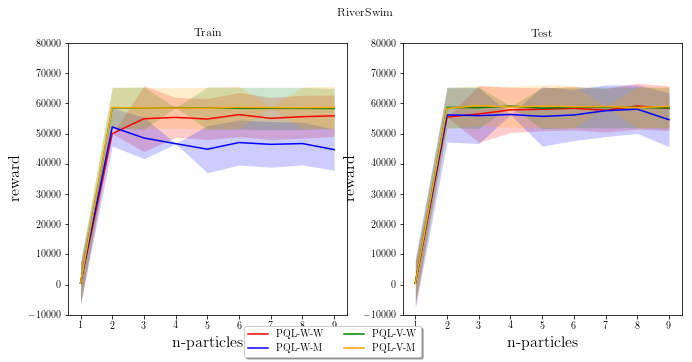

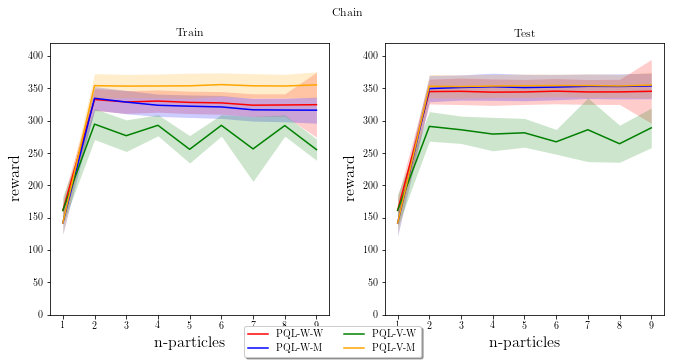

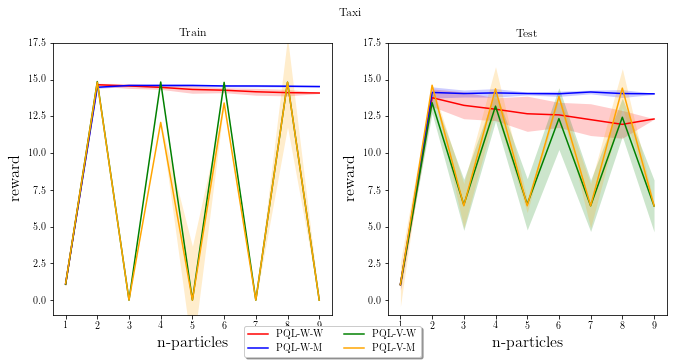

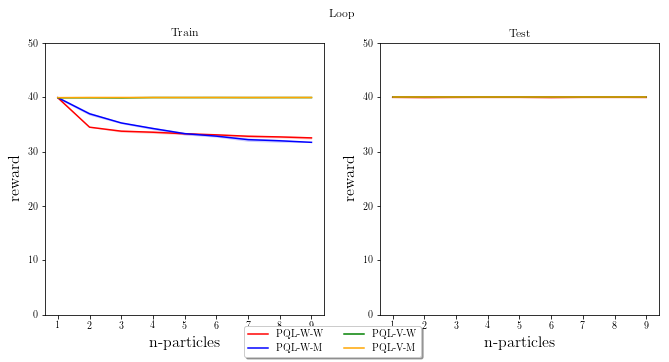

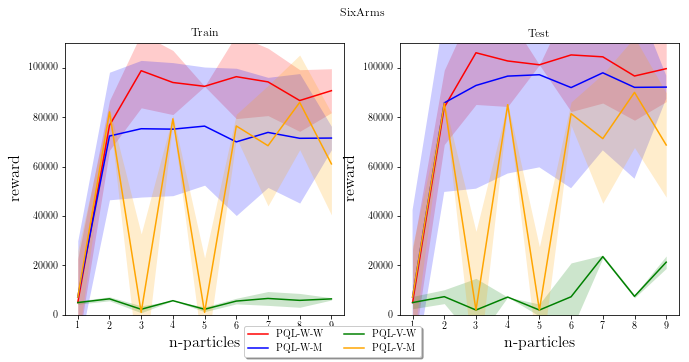

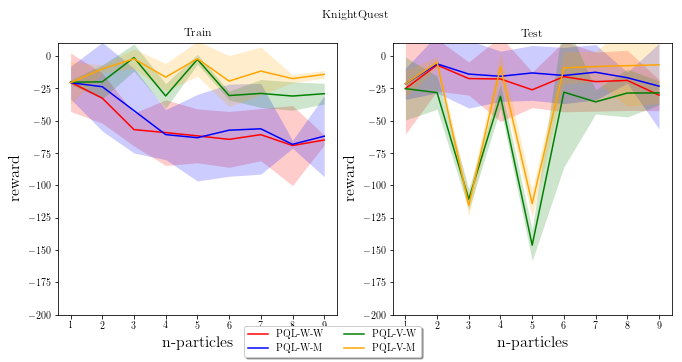

In [3]:
environments = ['RiverSwim','Chain','Taxi','Loop','SixArms','KnightQuest' ]
algorithms = ['particle-ql']
policies = [['weighted','vpi'],['boot','weighted'],['eps-greedy', 'boltzmann']]
updates = [['weighted','mean'],[''], ['']]
alg_to_label={
        'particle-ql':'PQL',
        'ql':'QL',
        'boot-ql':'BQL'
}
policy_to_label={
        'weighted':'W',
        'vpi':'V',
        'eps-greedy':'e-Gree',
        'boltzmann':'Boltz',
        'boot':'Boot'
}
update_to_label={
        'weighted':'W',
        'mean':'M',
        '':''
}
conf = 0.95
max_alpha=1
delta_alpha=0.05
limits=[(-10000,80000),(0,420),(-1,17.5),(0,50),(0,110000),(-200,10)]
for e,env in enumerate(environments):
    fig, ax = plt.subplots(1, 2, figsize=(11, 5))
    fig.suptitle(env)
    i = 0    
    for j, alg in enumerate(algorithms):
        for pi in policies[j]:
            for u in updates[j]:
                xs=[]
                ys=[]
                zs_train=[]
                zs_test=[]
                data_std_train=[]
                data_std_test=[]
                #print("%s_%s" %(pi,u))
                #results_noise_weighted_20_mean_0.2_1539254826.2738013_coef=0.15000000000000002.npy
                #results_weighted_9_weighted_0.2_double=False
                paths = glob.glob("./data_n_particles/"+env + "/results_" + pi + "_[123456789]_"+ u + "_*_double=False_*.npy")
                #print(paths)
                for p in paths:
                        n=float(str.split(p,'_')[4])
                        xs.append(n)
                        results = np.load(p)
                        #print(results.shape)
                        n_runs = results.shape[0]
                        try:
                            timesteps = np.cumsum(results[:, 0, :, 0][0])
                            cum_reward_train = results[:, 0, :, 3]
                            cum_reward_test = results[:, 1, :, 3]
                        except:
                            b = np.zeros(shape=results.shape+(11,))
                            for  (x,h,k),value in np.ndenumerate(results):
                                for l in range(11):
                                    b[x,h,k,l]=results[x,h,k][l]
                            results=b
                            timesteps = np.cumsum(results[:, 0, :, 0][0])
                            cum_reward_train = results[:, 0, :, 3]
                            cum_reward_test = results[:, 1, :, 3]
                        data_std_train.append(np.std(cum_reward_train, axis=0) + 1e-24)
                        zs_train.append(np.mean(cum_reward_train,axis=0))
                        data_std_test.append(np.std(cum_reward_test, axis=0) + 1e-24)
                        zs_test.append(np.mean(cum_reward_test,axis=0))
                ys=timesteps
                
                zs_train=np.array(zs_train)
                data_std_train=np.array(data_std_train)
                zs_test=np.array(zs_test)
                data_std_test=np.array(data_std_test)
                xs=np.array(xs)
                #print(np.array(xs).shape)
                #print(np.array(ys).shape)
                #print(zs.shape)
                zs_train=zs_train.mean(axis=1)
                data_std_train=data_std_train.mean(axis=1)
                zs_test=zs_test.mean(axis=1)
                data_std_test=data_std_test.mean(axis=1)
                
                inds=xs.argsort()
                col = colors[i]
                zs_test=zs_test[inds]
                zs_train=zs_train[inds]
                xs=np.sort(xs)
                label=alg_to_label[alg] + "-" + policy_to_label[pi] + "-" + update_to_label[u]
                lim=limits[e]
                
                ax[0].set_title('Train')
                ax[0].plot(xs,zs_train,label=label,color=col)
                ax[0].set_ylim(bottom=lim[0],top=lim[1])
                
                ax[1].set_title("Test")
                ax[1].plot(xs,zs_test,color=col)
                ax[1].set_ylim(bottom=lim[0],top=lim[1])
                
                ax[0].set_xlabel('n-particles', fontsize=AXIS_FONT_SIZE)
                ax[0].set_ylabel('reward', fontsize=AXIS_FONT_SIZE)
                ax[1].set_xlabel('n-particles', fontsize=AXIS_FONT_SIZE)
                ax[1].set_ylabel('reward', fontsize=AXIS_FONT_SIZE)
                #FILL REGION
                interval = sts.t.interval(conf, n_runs-1,loc=zs_train,scale=data_std_train/np.sqrt(n_runs))
                
                ax[0].fill_between(xs, interval[0], interval[1], alpha=0.2, color=col, linewidth=0.)
                
                interval = sts.t.interval(conf, n_runs-1,loc=zs_test,scale=data_std_test/np.sqrt(n_runs))
                ax[1].fill_between(xs, interval[0], interval[1], alpha=0.2, color=col, linewidth=0.)
                
                #3D PLOT CODE
                #Xm,Ym=np.meshgrid(np.array(ys),np.array(xs))
                #ax=Axes3D(plt.gcf())
                #ax.plot_surface(Xm,Ym,zs,cmap=cm.coolwarm,linewidth=0, antialiased=False)
                #ax.view_init(azim=0, elev=10
                
                i+=1
    lgd=fig.legend(loc='lower center', 
                          ncol=2, fancybox=True, shadow=True,bbox_to_anchor=(0.42, 0))
    fig.savefig(env+".pdf",format='pdf',bbox_extra_artists=(lgd,), bbox_inches='tight')